# Control: Técnicas Computacionales para Radio Interferometrı́a

## Grupo B – Conversión de Coordenadas y Simulación uv

## Importaciones

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timezone, timedelta
import pandas as pd
from zoneinfo import ZoneInfo  # Python 3.9+
# from astropy.coordinates import SkyCoord, EarthLocation, AltAz
# from astropy.time import Time
# import astropy.units as u
import datetime as dt

## Funciones

In [2]:
def deg2rad(deg): return deg*np.pi/180.0

def hms_to_rad(h, m=0, s=0):   # horas de RA → radianes
    return ((h + m/60 + s/3600) * 15.0) * np.pi/180.0

def rad_to_deg(rad): return rad*180.0/np.pi

def dms_to_rad(sign, d, m, s):
    deg = abs(d) + m/60.0 + s/3600.0
    return np.radians(deg if sign >= 0 else -deg)

def rad_to_hms(rad):
    rad = rad % (2*np.pi)
    total_hours = rad * 12/np.pi
    h = int(total_hours)
    m = int((total_hours - h)*60)
    s = (total_hours - h - m/60)*3600
    return h, m, s

def rad_to_dms(rad):
    deg = np.degrees(rad)
    sign = "-" if deg < 0 else "+"
    deg = abs(deg)
    d = int(deg)
    m = int((deg - d)*60)
    s = (deg - d - m/60)*3600
    return sign, d, m, s

def r_eq(alpha, delta):
    cd, ca = np.cos(delta), np.cos(alpha)
    sd, sa = np.sin(delta), np.sin(alpha)
    return np.array([cd*ca, cd*sa, sd])

def Rz(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([
        [c, -s, 0],
        [s, c, 0],
        [0, 0, 1]
    ])

def Ry(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([
        [c, 0, s],
        [0, 1, 0],
        [-s, 0, c]
    ])

def eq_to_hor(alpha, delta, phi, lst):
# Correct "only rotations" method:
# 1) rotate by -LST around z (into hour-angle frame)
# 2) rotate by +phi around y (tilt by latitude)
# 3) pick components as [E,N,U] = [-y2, z2, x2]
    v1 = Rz(-lst) @ r_eq(alpha, delta)
    v2 = Ry(phi) @ v1
    U = v2[0]
    E = v2[1]
    N = v2[2]
    a = np.arcsin(np.clip(U, -1.0, 1.0))
    Az = np.mod(np.arctan2(E, N), 2*np.pi)
    return a, Az

def eq_to_hor_scalar(alpha, delta, phi, lst):
    H = lst - alpha
    sphi, cphi = np.sin(phi), np.cos(phi)
    sdel, cdel = np.sin(delta), np.cos(delta)
    sH,   cH   = np.sin(H),    np.cos(H)

    sin_h = sphi*sdel + cphi*cdel*cH
    sin_h = np.clip(sin_h, -1.0, 1.0)
    h = np.arcsin(sin_h)
    cos_h = max(np.cos(h), 1e-15)

    sinA = (-cdel * sH) / cos_h
    cosA = (sdel - sphi*sin_h) / (cphi * cos_h)

    # A = np.arcsin(sinA)

    A = np.mod(np.arctan2(sinA, cosA), 2*np.pi)
    return h, A

def jd_from_datetime(dt_utc: datetime) -> float:
    """
    Convierte un datetime (aware, en UTC) a Julian Date (JD).
    """
    if dt_utc.tzinfo is None:
        raise ValueError("dt_utc debe ser timezone-aware en UTC")
    # Unix epoch -> JD: JD = (seg/86400) + 2440587.5
    return dt_utc.timestamp() / 86400.0 + 2440587.5

def gmst_hours_from_jd(JD: float) -> float:
    D = JD - 2451545.0
    GMST = 18.697374558 + 24.06570982441908 * D
    return GMST % 24.0

def lst_from_utc(dt_utc: datetime, lon_deg_east: float):
    """
    Calcula LST a partir de fecha-hora UTC y longitud (Este positivo, Oeste negativo).
    Retorna (LST_horas, LST_radianes)
    """
    JD   = jd_from_datetime(dt_utc)
    GMST = gmst_hours_from_jd(JD)
    LST_h = (GMST + lon_deg_east / 15.0) % 24.0
    LST_rad = (LST_h / 24.0) * 2.0 * np.pi
    return LST_h, LST_rad

# ========== Detección de ventanas sobre umbral ==========
def windows_over_threshold(times_local, alt_deg_series, threshold=20.0, min_hours=0.0):
    alts = np.asarray(alt_deg_series, dtype=float)
    n = len(alts)
    intervals = []
    in_run = False
    run_start = None

    for i in range(n):
        above = alts[i] > threshold
        # Si estamos sobre el threshold nos ponemos "en racha"
        if above and not in_run:
            in_run = True
            run_start = i
        # Si ya no estamos sobre el threshold y seguimos "en racha"
        elif not above and in_run:
            # Se define el inicio y fin de la ventana
            t0 = times_local[run_start]
            t1 = times_local[i-1]
            # Se calcula la duracion de la ventana
            dur_h = (t1 - t0).total_seconds()/3600.0
            # Se guarda la ventana solo si es mayor o igual al minimo que definimos en horas
            if dur_h >= min_hours:
                intervals.append((t0, t1, dur_h))
            in_run = False
    # Si se termina el arreglo de tiempos y seguimos en ventana dura hasta el último timestamp
    if in_run:
        t0 = times_local[run_start]
        t1 = times_local[-1]
        dur_h = (t1 - t0).total_seconds()/3600.0
        if dur_h >= min_hours:
            intervals.append((t0, t1, dur_h))
    return intervals

def baseline_to_XYZ(E, N, U, Az, El, lat):
    """
    Convierte un baseline ENU en coordenadas (X,Y,Z) de la fuente
    usando Az, El y latitud del observatorio.
    
    Parámetros:
        E, N, U : componentes del baseline en ENU (arrays o floats)
        Az      : acimut de la FUENTE (rad)
        El      : elevación de la FUENTE (rad)
        lat     : latitud del observatorio (rad)
    """
    b_norm = np.sqrt(E**2 + N**2 + U**2)

    X = b_norm * ( np.sin(El)*np.cos(lat) - np.cos(El)*np.sin(lat)*np.cos(Az) )
    Y = b_norm * ( np.sin(Az)*np.cos(El) )
    Z = b_norm * ( np.sin(El)*np.sin(lat) + np.cos(El)*np.cos(lat)*np.cos(Az) )

    return X, Y, Z

# ---------- helpers de unidades ----------
def wrap_pm_pi(x):
    """Envuelve a (-pi, pi]."""
    return (x + np.pi) % (2*np.pi) - np.pi

def wrap_0_2pi(x):
    return x % (2*np.pi)

# ---------- 1) muestreo de LST ----------
def lst_grid(LST_ini_h, LST_fin_h, step_minutes=5):
    """
    Genera una grilla de LST entre LST_ini_h y LST_fin_h (ambas en HORAS),
    con paso 'step_minutes'. Maneja wrap de 24h.
    Retorna (lst_h_array, lst_rad_array).
    """
    step_h = step_minutes / 60.0
    a, b = float(LST_ini_h), float(LST_fin_h)
    if b < a:      # cruza por 0h
        b += 24.0
    lst_h = np.arange(a, b + 1e-9, step_h)
    lst_h_mod = lst_h % 24.0
    lst_rad = lst_h_mod / 24.0 * 2*np.pi
    return lst_h_mod, lst_rad

# ---------- 2) H = LST - RA ----------
def hour_angle_series(lst_rad, ra_rad):
    """
    lst_rad: array de LST en rad
    ra_rad : escalar (AR del objeto) en rad
    Retorna H envuelto en (-pi, pi].
    """
    H = lst_rad - ra_rad
    return wrap_pm_pi(H)

# ---------- 3) (X,Y,Z) -> (u,v,w) ----------
def xyz_to_uvw(X, Y, Z, H, dec):
    """
    Aplica la matriz:
      [ u ]   [ sinH              cosH           0 ] [ X ]
      [ v ] = [ -sinδ cosH   sinδ sinH      cosδ ] [ Y ]
      [ w ]   [  cosδ cosH  -cosδ sinH      sinδ ] [ Z ]
    X,Y,Z: arrays (o escalares) del baseline en el marco ecuatorial (mismos shapes o broadcastables)
    H:     array de hora-ángulo (rad) (misma longitud que el eje temporal)
    dec:   escalar (rad), declinación del objeto
    Retorna (u, v, w) con broadcasting temporal.
    """
    sinH, cosH = np.sin(H), np.cos(H)
    sinD, cosD = np.sin(dec), np.cos(dec)

    u =  X*sinH + Y*cosH
    v = -X*sinD*cosH + Y*sinD*sinH + Z*cosD
    w =  X*cosD*cosH - Y*cosD*sinH + Z*sinD
    return u, v, w

# ---------- 4) opcional: pasar a longitudes de onda ----------
def to_wavelengths(u, v, w, wavelength_m):
    """Convierte (u,v,w) [m] a [λ]."""
    lam = float(wavelength_m)
    return u/lam, v/lam, w/lam

# ---------- 5) parseo de tus objetos ----------
def ra_from_tuple(t):     # (h, m, s)
    h, m, s = t
    return hms_to_rad(h, m, s)

def dec_from_tuple(t):    # (sign, d, m, s)
    sgn, d, m, s = t
    return dms_to_rad(sgn, d, m, s)

def uv_to_km(u, v, unit='m', wavelength_m=None):
    """
    Convierte u,v a kilómetros para graficar.
    - unit='m'      : u,v están en metros (longitud física del baseline proyectado).
    - unit='lambda' : u,v están en longitudes de onda; requiere wavelength_m.
    Retorna (u_km, v_km) con el mismo shape.
    """
    if unit == 'm':
        u_m, v_m = u, v
    elif unit == 'lambda':
        if wavelength_m is None:
            raise ValueError("Si unit='lambda', debes pasar wavelength_m.")
        u_m, v_m = u * wavelength_m, v * wavelength_m
    else:
        raise ValueError("unit debe ser 'm' o 'lambda'")
    return u_m / 1000.0, v_m / 1000.0

def plot_uv_tracks(u, v, unit='m', wavelength_m=None, title=None,
                   stride=1, s=3, alpha=0.7, show_conjugate=True):
    """
    Dibuja los tracks uv.
    - u,v: arrays 2D (n_baselines, n_times) o 1D; se aplanan para scatter.
    - unit: 'm' o 'lambda' (si es 'lambda', se usa wavelength_m para pasar a km).
    - stride: submuestreo de puntos para aligerar (p.ej. 2 o 5).
    - s: tamaño de los puntos.
    - alpha: transparencia.
    - show_conjugate: también dibuja (-u,-v).
    """
    u_km, v_km = uv_to_km(u, v, unit=unit, wavelength_m=wavelength_m)

    U = np.ravel(u_km)[::stride]
    V = np.ravel(v_km)[::stride]

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(U, V, s=s, alpha=alpha, linewidths=0, color='black')
    if show_conjugate:
        ax.scatter(-U, -V, s=s, alpha=alpha, linewidths=0, color='black')

    # punto central
    ax.scatter([0], [0], s=25, color='white', edgecolor='black', zorder=3)

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('u (km)')
    ax.set_ylabel('v (km)')
    if title:
        ax.set_title(title)
    ax.grid(True, linestyle=':', alpha=0.4)

    # marco similar a la referencia
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    plt.tight_layout()
    plt.show()

## Código

### 2.- Convertir sus coordenadas ecuatoriales (RA, Dec) a:
        -> Coordenadas horizontales (Alt, Az) para Santiago de Chile (lat. −33.45◦) en una fecha y hora determinada.
        -> Coordenadas galácticas.

In [3]:
# Coordenadas horizontales
############################################

# ==============================
# 1.1 Fuente 1 (M42)
# ==============================
alpha = hms_to_rad(5, 36, 31)
delta = dms_to_rad(-1, 5, 22, 28)

# ==============================
# 1.2 Fuente 2 (Pulsar NGC 5907)
# ==============================
alpha2 = hms_to_rad(15, 15, 53.2)
delta2 = dms_to_rad(+1, 56, 19, 48)

# ==============================
# 1.3 Fuente 3 (Messier 087)
# ==============================
alpha3 = hms_to_rad(12, 30, 49.4233)
delta3 = dms_to_rad(+1, 12, 23, 28.043)

# ==============================
# 2. Observador (Santiago de Chile)
# ==============================
phi = np.radians(-33.45)        # latitud
lon_deg_east = -70.66           # longitud

# ==============================
# 3. Definir hora local como string
# ==============================
fecha_str = "2025-10-01 18:30:00"   # hora de Santiago
tz_scl = ZoneInfo("America/Santiago")

# convertir string -> datetime con tz Santiago
dt_local = datetime.strptime(fecha_str, "%Y-%m-%d %H:%M:%S").replace(tzinfo=tz_scl)

# pasar a UTC
dt_utc = dt_local.astimezone(timezone.utc)

# UTC AHORA
# dt_utc = datetime.now(timezone.utc)

# ==============================
# 4. Calcular LST con UTC
# ==============================
lst_h, lst_r = lst_from_utc(dt_utc, lon_deg_east)

# ==============================
# 5. Convertir a horizontales
# ==============================
a1, az1 = eq_to_hor_scalar(alpha,  delta,  phi, hms_to_rad(lst_h))
a2, az2 = eq_to_hor_scalar(alpha2, delta2, phi, hms_to_rad(lst_h))
a3, az3 = eq_to_hor_scalar(alpha3, delta3, phi, hms_to_rad(lst_h))

print("Hora local:", dt_local)
print("Hora UTC:  ", dt_utc)

print("\nM42")
print("#########################")
print(f"Altitud (a)  = {a1:.4f}")
print(f"Azimut  (Az) = {az1:.4f}")

print("\nPulsar NGC 5907")
print("#########################")
print(f"Altitud (a)  = {a2:.4f}")
print(f"Azimut  (Az) = {az2:.4f}")

print("\nMessier 087")
print("#########################")
print(f"Altitud (a)  = {a3:.4f}")
print(f"Azimut  (Az) = {az3:.4f}")

# Coordenadas galácticas
############################################
# (RA, Dec) -> (l, b) usando NGP y ángulo de posición

# ==============================
# 1. Constantes de referencia
# ==============================
alpha_NGP  = hms_to_rad(12, 51, 26.28)     # RA del NGP
delta_NGP  = dms_to_rad(+1, 27, 7, 41.7)   # Dec del NGP
theta      = dms_to_rad(+1, 123, 55, 55.2) # Ángulo galáctico

# Pre-cálculos del NGP
sin_delNGP = np.sin(delta_NGP)
cos_delNGP = np.cos(delta_NGP)

# ==============================
# 2. Fuente 1: M42
# ==============================
sin_del = np.sin(delta)
cos_del = np.cos(delta)

Y = cos_del * np.sin(alpha - alpha_NGP)
X = (np.sin(delta)*cos_delNGP - cos_del*sin_delNGP*np.cos(alpha - alpha_NGP))

b1 = np.arcsin(sin_delNGP*np.sin(delta) + cos_delNGP*cos_del*np.cos(alpha - alpha_NGP))
l1 = theta + np.arctan2(Y, X)
l1 = (l1 + 2*np.pi) % (2*np.pi)

print("\nM42")
print("#########################")
print(f"Latitud galáctica  (b) = {b1:.4f} rad")
print(f"Longitud galáctica (l) = {l1:.4f} rad")

# ==============================
# 3. Fuente 2: Pulsar NGC 5907
# ==============================
sin_del = np.sin(delta2)
cos_del = np.cos(delta2)

Y = cos_del * np.sin(alpha2 - alpha_NGP)
X = (np.sin(delta2)*cos_delNGP - cos_del*sin_delNGP*np.cos(alpha2 - alpha_NGP))

b2 = np.arcsin(sin_delNGP*np.sin(delta2) + cos_delNGP*cos_del*np.cos(alpha2 - alpha_NGP))
l2 = theta + np.arctan2(Y, X)
l2 = (l2 + 2*np.pi) % (2*np.pi)

print("\nPulsar NGC 5907")
print("#########################")
print(f"Latitud galáctica  (b) = {b2:.4f} rad")
print(f"Longitud galáctica (l) = {l2:.4f} rad")

# ==============================
# 4. Fuente 3: Messier 087
# ==============================
sin_del = np.sin(delta3)
cos_del = np.cos(delta3)

Y = cos_del * np.sin(alpha3 - alpha_NGP)
X = (np.sin(delta3)*cos_delNGP - cos_del*sin_delNGP*np.cos(alpha3 - alpha_NGP))

b3 = np.arcsin(sin_delNGP*np.sin(delta3) + cos_delNGP*cos_del*np.cos(alpha3 - alpha_NGP))
l3 = theta + np.arctan2(Y, X)
l3 = (l3 + 2*np.pi) % (2*np.pi)

print("\nMessier 087")
print("#########################")
print(f"Latitud galáctica  (b) = {b3:.4f} rad")
print(f"Longitud galáctica (l) = {l3:.4f} rad")

Hora local: 2025-10-01 18:30:00-03:00
Hora UTC:   2025-10-01 21:30:00+00:00

M42
#########################
Altitud (a)  = -0.8928
Azimut  (Az) = 3.1811

Pulsar NGC 5907
#########################
Altitud (a)  = -0.0741
Azimut  (Az) = 5.9693

Messier 087
#########################
Altitud (a)  = 0.0928
Azimut  (Az) = 5.0379

M42
#########################
Latitud galáctica  (b) = -0.3334 rad
Longitud galáctica (l) = 0.6583 rad

Pulsar NGC 5907
#########################
Latitud galáctica  (b) = 0.8916 rad
Longitud galáctica (l) = 2.7101 rad

Messier 087
#########################
Latitud galáctica  (b) = 1.3001 rad
Longitud galáctica (l) = 5.6389 rad


### 3.- Determinar en qu ́e horarios las fuentes son observables (Altura > 20◦).


Messier M42 (Great Orion Nebula)
  Alt>20° desde 01:57 hasta 11:11  (duración 9.23 h)

Pulsar NGC 5907
  No supera 20° en la ventana 18:00–06:00.

Messier 087
  Alt>20° desde 09:46 hasta 17:08  (duración 7.37 h)


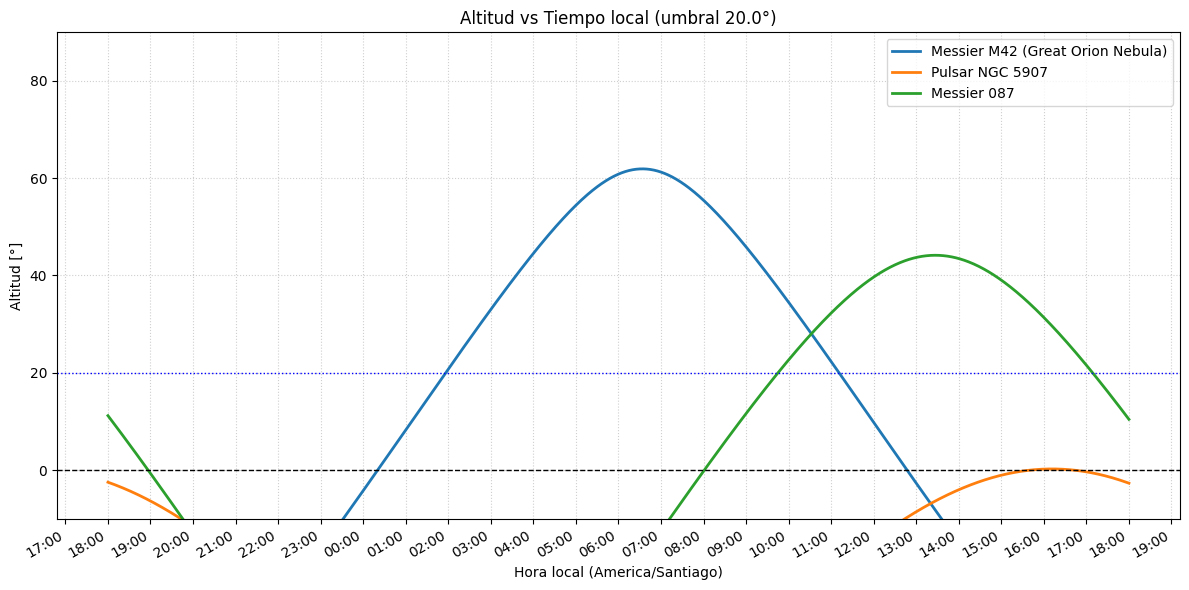

In [4]:
# ========== Objetos nuevos ==========
objetos = [
    ("Messier M42 (Great Orion Nebula)",  (5,36,31),        (-1, 5,22,28)),
    ("Pulsar NGC 5907",                   (15,15,53.2),     ( +1,56,19,48)),
    ("Messier 087",                       (12,30,49.4233),  (+1,12,23,28.043)),
    # ("Sirius (α CMa)",                    (6,45,9),         (-1,16,42,58)),
    # ("Canopus (α Car)",                   (6,23,57),        (-1,52,41,44)),
    # ("α Centauri",                        (14,39,36),       (-1,60,50,2)),
    # ("Betelgeuse (α Ori)",                (5,55,10),        (+1,7,24,25)),
    # ("Rigel (β Ori)",                     (5,14,32),        (-1,8,12,6)),
    # ("M31 (Andrómeda)",                   (0,42,44.3),      (+1,41,16,9)),
    # ("M42 (Orión)",                       (5,35,17.3),      (-1,5,23,28)),
    # ("47 Tuc (NGC 104)",                  (0,24,5),         (-1,72,4,52)),
    # ("LMC (centro)",                      (5,23,35),        (-1,69,45,22)),
]

altura_deg = 20.0

# ========== Construir malla nocturna y evaluar Alt>20° ==========

# Ubicación: Santiago
tz = ZoneInfo("America/Santiago")

# Malla nocturna local (18:00 -> 06:00)


# PARA DEFINIR FECHA Y HORA DETERMINADA
# # tu fecha como string
fecha_str = "2025-10-01 18:30:00"
# # parsear string -> datetime y agregar zona horaria
now_local = datetime.strptime(fecha_str, "%Y-%m-%d %H:%M:%S").replace(tzinfo=tz)

day = now_local.date()
t_start = datetime(day.year, day.month, day.day, 18, 0, tzinfo=tz)

# Si estamos en madrugada, revisar la noche anterior
if now_local.hour < 6:
    t_start -= timedelta(days=1)

t_end = t_start + timedelta(hours=24)

step_min = 1 # cada cuantos minutos se revisa el cielo
times_local = []
t = t_start
while t <= t_end:
    times_local.append(t) # Se guardan los instantes de tiempo de observación
    t += timedelta(minutes=step_min)

# Precalcular LST por timestamp
lst_rads = []
for tl in times_local:
    _, lst_rad = lst_from_utc(tl.astimezone(timezone.utc), lon_deg_east)
    lst_rads.append(lst_rad)

# Para cada objeto: calcular a(t), detectar ventanas Alt>20°
resultados = []  # guardamos curvas para graficar 
for name, ra_hms, dec_dms in objetos:
    alpha = hms_to_rad(*ra_hms)
    sgn, d, m, s = dec_dms
    delta = dms_to_rad(sgn, d, m, s)

    alts_deg = []
    for lst_rad in lst_rads:
        a, _A = eq_to_hor(alpha, delta, phi, lst_rad)
        alts_deg.append(np.degrees(a))

    intervals = windows_over_threshold(times_local, alts_deg, threshold=altura_deg, min_hours=0.0)

    print(f"\n{name}")
    if not intervals:
        print("  No supera 20° en la ventana 18:00–06:00.")
    else:
        for t0, t1, dur_h in intervals:
            print(f"  Alt>20° desde {t0.strftime('%H:%M')} hasta {t1.strftime('%H:%M')}  (duración {dur_h:.2f} h)")

    resultados.append((name, alts_deg))  # guardamos para graficar

# ========== Gráfico ==========

plt.figure(figsize=(12,6))
for name, alts_deg in resultados:
    plt.plot(times_local, alts_deg, label=name, linewidth=2)

# Líneas de referencia
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.axhline(altura_deg, color="blue", linestyle=":", linewidth=1)

# Formato de ejes
plt.title(f"Altitud vs Tiempo local (umbral {altura_deg}°)")
plt.ylabel("Altitud [°]")
plt.xlabel("Hora local (America/Santiago)")
plt.ylim(-10, 90)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M", tz=tz))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gcf().autofmt_xdate()

plt.grid(True, linestyle=":", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

### 4.-Simular las coordenadas uv resultantes para una red de antenas simple:
        -> Usar posiciones reales (ejemplo: VLA, ALMA compacta).
        -> Simular una observaci ́on de duración acorde al tiempo que la fuente es observable desde Santiago (m ́ınimo 2 horas, m ́aximo 8 horas).
        -> Mostrar la cobertura uv obtenida para esta observación.

Centro ENU del arreglo: [ 837.35156666 -413.38164879  -62.61610241]
Número de baselines: 903
Ejemplo de baselines:
 [[-426.2418285  -156.1337866     0.96892922]
 [-339.1333564   665.4559711     4.92549877]
 [-692.6991941   336.111345      0.7916714 ]
 [ 338.301166   -362.8489866    -2.96127433]
 [ 560.7821016   195.6189692   -17.32661853]]
E (903,)
N (903,)
U (903,)
Az (903,)
Alt (903,)
Baseline 0: |b|=453.94 m, Az=-110.12°, El=0.12°
Baseline 1: |b|=746.91 m, Az=-27.00°, El=0.38°
Baseline 2: |b|=769.94 m, Az=-64.12°, El=0.06°
Baseline 3: |b|=496.10 m, Az=137.01°, El=-0.34°
Baseline 4: |b|=594.17 m, Az=70.77°, El=-1.67°
XYZ [[  -85.25391699  -426.2418285   -130.80698674]
 [  370.9150431   -339.1333564    552.51962935]
 [  185.92816738  -692.6991941    280.00389204]
 ...
 [ 4548.22421066 -1594.006       6681.91273069]
 [ 5457.21758398 -1554.604       8082.81351063]
 [  908.99337332    39.402       1400.90077993]]
Baseline 0: X=-85.25, Y=-426.24, Z=-130.81
Baseline 1: X=370.92, Y=-339.13,

C:\Users\vicen\AppData\Local\Temp\ipykernel_28740\3082389607.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


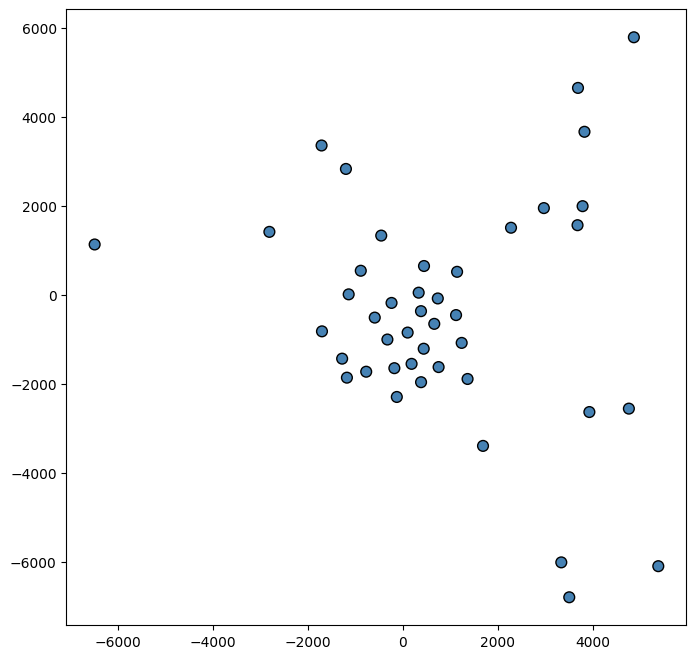

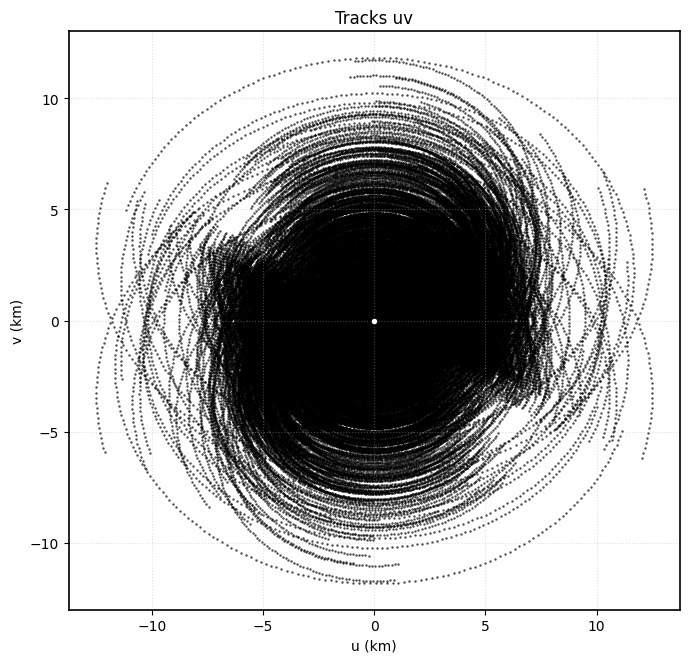

In [13]:
df = pd.read_csv(
    "../antenna_arrays/alma.cycle10.9.cfg", 
    delim_whitespace=True,     # separador: espacios o tabs
    comment="#",               # ignora todo lo que empiece con #
    header=None,               # no hay cabecera en el archivo
    names=["x", "y", "z", "diam", "pad"]  # nombres de columnas
)

plt.figure(figsize=(8, 8))
plt.scatter(df["x"], df["y"], s=df["diam"]*5, c="steelblue", edgecolor="black")

'''
# Añadir etiquetas (pad#) al lado de cada antena
for _, row in df.iterrows():
    plt.text(row["x"]+0.5, row["y"]+0.5, row["pad"], fontsize=9)
'''

# plt.title("Topología del arreglo de antenas", fontsize=14)
# plt.xlabel("X [m] (local tangent plane)")
# plt.ylabel("Y [m] (local tangent plane)")
# plt.axis("equal")   # Escala 1:1 para no deformar
# plt.grid(True, linestyle="--", alpha=0.5)
# plt.show()

center = df[["x","y","z"]].mean().values
print("Centro ENU del arreglo:", center)

# Posiciones relativas al centro
ant_pos_rel = df[["x","y","z"]].values - center

N = len(ant_pos_rel)
baselines = []

# Todas las combinaciones de antenas sin repetir
for i in range(N):
    for j in range(i+1, N):
        baselines.append(ant_pos_rel[j] - ant_pos_rel[i])

baselines = np.array(baselines)
print("Número de baselines:", len(baselines))
print("Ejemplo de baselines:\n", baselines[:5])

E = baselines[:, 0]
N = baselines[:, 1]
U = baselines[:, 2]

print("E", E.shape)
print("N", N.shape)
print("U", U.shape)

# Distancia horizontal
b_hor = np.sqrt(E**2 + N**2)

# Azimut y elevación
A = np.arctan2(E, N)   # radianes
E_angle = np.arctan2(U, b_hor)

print("Az", A.shape)
print("Alt", E_angle.shape)


# Módulo del baseline
b_norm = np.linalg.norm(baselines, axis=1)

# Para ver un ejemplo
for i in range(5):
    print(f"Baseline {i}: |b|={b_norm[i]:.2f} m, Az={np.degrees(A[i]):.2f}°, El={np.degrees(E_angle[i]):.2f}°")

latitud = np.radians(-33.45)

X, Y, Z = baseline_to_XYZ(E, N, U, A, E_angle, latitud)

print("XYZ", np.stack([X, Y, Z], axis=-1))

for i in range(5):
    print(f"Baseline {i}: X={X[i]:.2f}, Y={Y[i]:.2f}, Z={Z[i]:.2f}")

# 1) define LST inicial y final (horas)
LST_ini, LST_fin = 13.0, 03.0   # ejemplo: de 18h a 06h (cruza 0h)

# 2) grilla de LST (cada 5 min)
lst_h, lst_rad = lst_grid(LST_ini, LST_fin, step_minutes=5)

name, ra_t, dec_t = objetos[1]
alpha = ra_from_tuple(ra_t)
delta = dec_from_tuple(dec_t)

# 4) H(t)
H = hour_angle_series(lst_rad, alpha)

# 5) aplica rotación a TODOS los baselines a la vez (broadcast temporal)
#    X,Y,Z con shape (n_baselines,) -> tras la operación obtendrás (n_baselines, n_times)
#    Para eso, añadimos ejes: X[:,None] y H[None,:]
u, v, w = xyz_to_uvw(X[:,None], Y[:,None], Z[:,None], H[None,:], delta)

# 6) (opcional) pasar a λ (elige tu frecuencia)
# c = 299792458.0
# freq = 100e9
# lam = c/freq
# uλ, vλ, wλ = to_wavelengths(u, v, w, lam)

plot_uv_tracks(u, v, unit='m', title='Tracks uv')

### 5.- Analizar cómo la cobertura uv condiciona la reconstrucci ́on de las imágenes, conectando con lo que el Grupo A presenta.

#### La cobertura uv
Cuando usamos un interferómetro (como ALMA) no hacemos una foto directa del cielo. Cada par de antenas mide solo una parte de la información espacial de la fuente, que se representa en el plano uv.

#### Si faltan puntos, falta información
Para reconstruir la imagen necesitamos llenar bien ese plano. Si solo tenemos algunos puntos, la imagen que obtenemos al reconstruir sale borrosa y con artefactos, porque el instrumento ve el cielo a través de un dirty beam.

#### Qué pasa según la cobertura

Si los puntos están bien distribuidos y densos, obtenemos buena resolución y una imagen más fiel.
Si hay huecos, aparecen manchas, lóbulos y se pierden detalles o estructuras grandes.
Longitud de las baselines (distancia entre antenas)
Antenas muy separadas (baselines largas) → vemos detalles muy finos, pero perdemos sensibilidad a estructuras grandes.
Antenas cercanas (baselines cortas) → vemos estructuras extendidas, pero la imagen tiene menos resolución.